# CS Beacon Config

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import requests
import urllib.request
from bs4 import BeautifulSoup
from pathlib import Path
from datetime import datetime, timezone
from email.utils import parsedate_to_datetime
from tqdm import tqdm

In [103]:
url = "https://beaconbeagle.com/data/"
response = requests.head(url)
page = requests.get(url).text
output_dir = "config"
os.makedirs(output_dir, exist_ok=True)
json_data = Path("config")

pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
soup = BeautifulSoup(page, 'html.parser')

# Filter only files ending with ".nc"
links = [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith('.json')]

print("Found files:")
for link in links:
    print(link)

In [109]:
for link in tqdm(links, desc="Downloading Files"):
    filename = os.path.join(output_dir, link.split('/')[-1])
    download = True
    if os.path.exists(filename):
        try:
            req = urllib.request.Request(link, method="HEAD")
            with urllib.request.urlopen(req) as resp:
                last_modified = resp.headers.get("Last-Modified")
            if last_modified:
                remote_dt = parsedate_to_datetime(last_modified)
                local_dt = datetime.fromtimestamp(
                    os.path.getmtime(filename), tz=timezone.utc
                )
                if remote_dt <= local_dt:
                    # skip file since its up to date
                    download = False
        except Exception as e:
            tqdm.write(f"HEAD check failed for {filename}: {e}")
        if not download:
            continue
        tqdm.write(f"Updating {filename}")
    else:   
        tqdm.write(f"Downloading: {filename}")
    urllib.request.urlretrieve(link, filename)

In [110]:
dfs = []

for file in json_data.glob("*.json"):
    with open(file) as f:
        data = json.load(f)

    df = pd.json_normalize(data)
    df["source_file"] = file.name  # optional but very useful
    dfs.append(df)

In [111]:
final_df = pd.concat(dfs, ignore_index=True)
final_df["timestamp"] = pd.to_datetime(final_df["timestamp"])
final_df[["ip", "port", "arch"]] = final_df["source_file"].str.extract(r"(?P<ip>[\d\.]+)-(?P<port>\d+)_(?P<arch>x\d{2})config\.json")

In [112]:
final_df["source_file"].nunique()

562

# Data Analysis Begins Here

## Group by listener port

In [113]:
final_df["settings.SETTING_PORT"].nunique()

116

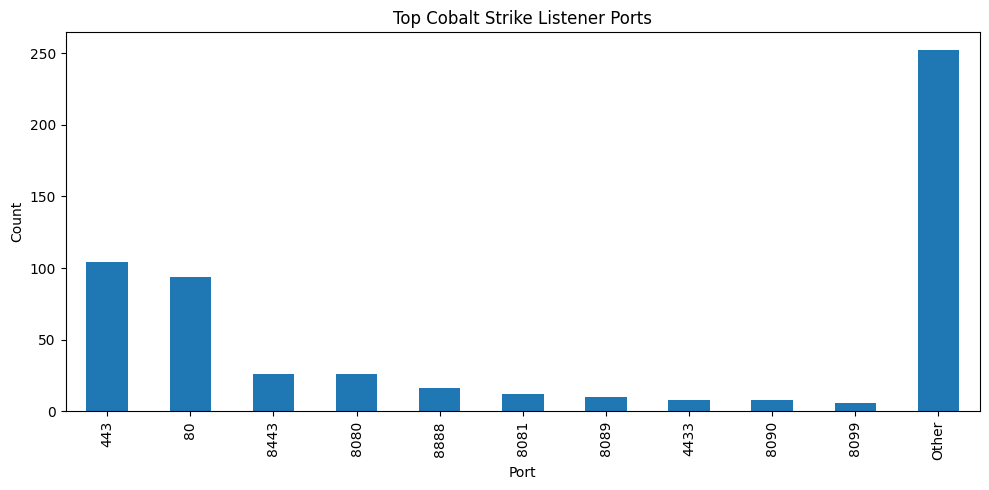

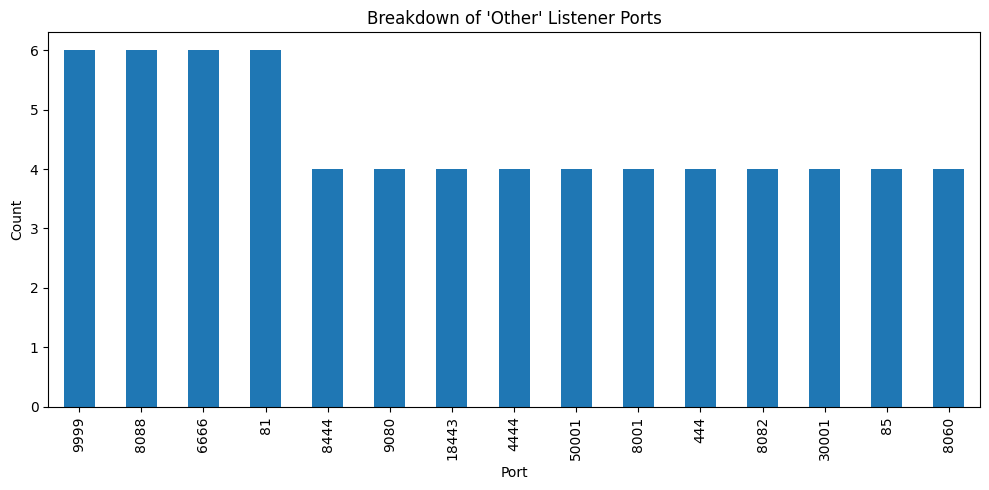

In [114]:
num_ports = 10
port_count = final_df["settings.SETTING_PORT"].value_counts()
top_ports = port_count.head(num_ports)
other_ports = port_count.iloc[num_ports:]

top_ports = pd.concat([
    top_ports,
    pd.Series({"Other": other_ports.sum()})
])

top_ports.plot(kind="bar", figsize=(10, 5))
plt.title("Top Cobalt Strike Listener Ports")
plt.xlabel("Port")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Second bar graph for the "Other" column
other_num_ports = 15
other_ports.head(other_num_ports).plot(kind="bar", figsize=(10, 5))
plt.title("Breakdown of 'Other' Listener Ports")
plt.xlabel("Port")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [127]:
domains = final_df[final_df["settings.SETTING_PORT"] == 9999]
domains[["source_file","settings.SETTING_DOMAINS"]]

,source_file,settings.SETTING_DOMAINS
78,150.187.25.242-9999_x64config.json,"150.187.25.242,/pixel,116.203.31.207,/j.ad"
226,117.72.242.9-9999_x64config.json,"117.72.242.9,/load"
244,49.235.177.231-9999_x86config.json,"49.235.177.231,/dpixel"
309,150.187.25.242-9999_x86config.json,"150.187.25.242,/en_US/all.js,116.203.31.207,/activity"
426,117.72.242.9-9999_x86config.json,"117.72.242.9,/ca"
432,49.235.177.231-9999_x64config.json,"49.235.177.231,/activity"


## Group by Version Number

In [52]:
version_num = final_df["version"].value_counts()

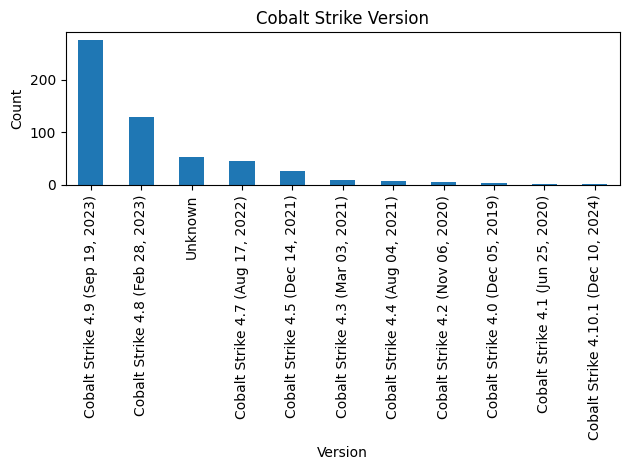

In [53]:
version_count = 11
version_list = final_df["version"].value_counts()
version_num = version_list.head(version_count)
version_num.plot(kind="bar")
plt.title("Cobalt Strike Version")
plt.xlabel("Version")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [145]:
final_df.groupby(["version", "settings.SETTING_WATERMARK"]).size().sort_values(ascending=False)

version                              settings.SETTING_WATERMARK
Cobalt Strike 4.9 (Sep 19, 2023)     987654321                     145
                                     666666666                     131
Cobalt Strike 4.8 (Feb 28, 2023)     987654321                     130
Cobalt Strike 4.7 (Aug 17, 2022)     391144938                      32
Unknown                              100000                         21
Cobalt Strike 4.5 (Dec 14, 2021)     100000                         21
Cobalt Strike 4.7 (Aug 17, 2022)     987654321                      14
Unknown                              987654321                       7
Cobalt Strike 4.3 (Mar 03, 2021)     426352781                       6
Unknown                              1234567890                      5
Cobalt Strike 4.4 (Aug 04, 2021)     1234567890                      5
Unknown                              305419896                       4
Cobalt Strike 4.0 (Dec 05, 2019)     305419896                       4
Cobalt Strike

## Group By Public Key

In [ ]:
final_df.groupby(["settings.SETTING_PUBKEY", "settings.SETTING_DOMAINS"]).size().sort_values(ascending=False)

In [172]:
pub_key_ip = final_df[final_df["settings.SETTING_PUBKEY"] == '640f18232741807f5bc93c7deaba8d09d302929a0e9fe5c0f877a956256df3d9']
pub_key_ip["ip"].unique()

array(['39.104.78.25', '8.138.222.215', '122.51.46.102', '118.89.73.78',
       '47.90.142.15', '1.15.25.148', '47.116.208.81', '47.236.149.142',
       '202.146.218.74'], dtype=object)

In [173]:
shared_infra = (
    final_df.groupby("settings.SETTING_PUBKEY")["settings.SETTING_DOMAINS"]
    .nunique()
    .loc[lambda x: x > 1]
    .index
)
result = (
    final_df[final_df["settings.SETTING_PUBKEY"].isin(shared_infra)]
    .groupby(["settings.SETTING_PUBKEY", "settings.SETTING_DOMAINS"])
    .size()
    .sort_values(ascending=False)
)

In [ ]:
result

### Compare architecture

In [185]:
df = final_df.copy()
df[["ip", "port", "arch"]] = df["source_file"].str.extract(r"(?P<ip>[\d\.]+)-(?P<port>\d+)_(?P<arch>x\d{2})config\.json")
arch = df.groupby(["ip", "port"])["arch"].nunique()
both_arch = arch[arch == 2].index
df_both_arch = df.set_index(["ip", "port"]).loc[both_arch].reset_index()
df_x86 = df_both_arch[df_both_arch["arch"] == "x86"].set_index(["ip", "port"])
df_x64 = df_both_arch[df_both_arch["arch"] == "x64"].set_index(["ip", "port"])

# Keep only columns to compare (drop source_file if needed)
cols_to_compare = [c for c in df.columns if c not in ["source_file", "ip", "port", "arch"]]

# Merge
comparison_df = df_x86[cols_to_compare].join(
    df_x64[cols_to_compare], lsuffix="_x86", rsuffix="_x64"
).reset_index()

In [187]:
comparison_df.head(5)

,ip,port,date_x86,timestamp_x86,hash_x86,version_x86,watermark_x86,trial_x86,protocol_x86,settings.SETTING_PROTOCOL_x86,settings.SETTING_PORT_x86,settings.SETTING_SLEEPTIME_x86,settings.SETTING_MAXGET_x86,settings.SETTING_JITTER_x86,settings.SETTING_PUBKEY_x86,settings.SETTING_DOMAINS_x86,settings.SETTING_DOMAIN_STRATEGY_x86,settings.SETTING_DOMAIN_STRATEGY_SECONDS_x86,settings.SETTING_DOMAIN_STRATEGY_FAIL_X_x86,settings.SETTING_DOMAIN_STRATEGY_FAIL_SECONDS_x86,settings.SETTING_SPAWNTO_x86,settings.SETTING_SPAWNTO_X86_x86,settings.SETTING_SPAWNTO_X64_x86,settings.SETTING_CRYPTO_SCHEME_x86,settings.SETTING_C2_VERB_GET_x86,settings.SETTING_C2_VERB_POST_x86,settings.SETTING_C2_CHUNK_POST_x86,settings.SETTING_WATERMARK_x86,settings.SETTING_WATERMARKHASH_x86,settings.SETTING_CLEANUP_x86,settings.SETTING_CFG_CAUTION_x86,settings.SETTING_MAX_RETRY_STRATEGY_ATTEMPTS_x86,settings.SETTING_MAX_RETRY_STRATEGY_INCREASE_x86,settings.SETTING_MAX_RETRY_STRATEGY_DURATION_x86,settings.SETTING_USERAGENT_x86,settings.SETTING_SUBMITURI_x86,settings.SETTING_C2_RECOVER_x86,settings.SETTING_C2_REQUEST_x86,settings.SETTING_C2_POSTREQ_x86,settings.SETTING_HOST_HEADER_x86,settings.SETTING_HTTP_NO_COOKIES_x86,settings.SETTING_PROXY_BEHAVIOR_x86,settings.SETTING_TCP_FRAME_HEADER_x86,settings.SETTING_SMB_FRAME_HEADER_x86,settings.SETTING_EXIT_FUNK_x86,settings.SETTING_KILLDATE_x86,settings.SETTING_GARGLE_NOOK_x86,settings.SETTING_PROCINJ_PERMS_I_x86,settings.SETTING_PROCINJ_PERMS_x86,settings.SETTING_PROCINJ_MINALLOC_x86,settings.SETTING_PROCINJ_TRANSFORM_X86_x86,settings.SETTING_PROCINJ_TRANSFORM_X64_x86,settings.SETTING_PROCINJ_STUB_x86,settings.SETTING_PROCINJ_EXECUTE_x86,settings.SETTING_PROCINJ_ALLOCATOR_x86,settings.SETTING_PROCINJ_BOF_REUSE_MEM_x86,settings.SETTING_BOF_ALLOCATOR_x86,settings.SETTING_MASKED_WATERMARK_x86,settings.SETTING_SYSCALL_METHOD_x86,settings.SETTING_DATA_STORE_SIZE_x86,settings.SETTING_GARGLE_SECTIONS_x86,settings.SETTING_MAXDNS_x86,settings.SETTING_PIPENAME_x86,settings.SETTING_DNS_IDLE_x86,settings.SETTING_DNS_SLEEP_x86,settings.SETTING_BEACON_GATE_x86,date_x64,timestamp_x64,hash_x64,version_x64,watermark_x64,trial_x64,protocol_x64,settings.SETTING_PROTOCOL_x64,settings.SETTING_PORT_x64,settings.SETTING_SLEEPTIME_x64,settings.SETTING_MAXGET_x64,settings.SETTING_JITTER_x64,settings.SETTING_PUBKEY_x64,settings.SETTING_DOMAINS_x64,settings.SETTING_DOMAIN_STRATEGY_x64,settings.SETTING_DOMAIN_STRATEGY_SECONDS_x64,settings.SETTING_DOMAIN_STRATEGY_FAIL_X_x64,settings.SETTING_DOMAIN_STRATEGY_FAIL_SECONDS_x64,settings.SETTING_SPAWNTO_x64,settings.SETTING_SPAWNTO_X86_x64,settings.SETTING_SPAWNTO_X64_x64,settings.SETTING_CRYPTO_SCHEME_x64,settings.SETTING_C2_VERB_GET_x64,settings.SETTING_C2_VERB_POST_x64,settings.SETTING_C2_CHUNK_POST_x64,settings.SETTING_WATERMARK_x64,settings.SETTING_WATERMARKHASH_x64,settings.SETTING_CLEANUP_x64,settings.SETTING_CFG_CAUTION_x64,settings.SETTING_MAX_RETRY_STRATEGY_ATTEMPTS_x64,settings.SETTING_MAX_RETRY_STRATEGY_INCREASE_x64,settings.SETTING_MAX_RETRY_STRATEGY_DURATION_x64,settings.SETTING_USERAGENT_x64,settings.SETTING_SUBMITURI_x64,settings.SETTING_C2_RECOVER_x64,settings.SETTING_C2_REQUEST_x64,settings.SETTING_C2_POSTREQ_x64,settings.SETTING_HOST_HEADER_x64,settings.SETTING_HTTP_NO_COOKIES_x64,settings.SETTING_PROXY_BEHAVIOR_x64,settings.SETTING_TCP_FRAME_HEADER_x64,settings.SETTING_SMB_FRAME_HEADER_x64,settings.SETTING_EXIT_FUNK_x64,settings.SETTING_KILLDATE_x64,settings.SETTING_GARGLE_NOOK_x64,settings.SETTING_PROCINJ_PERMS_I_x64,settings.SETTING_PROCINJ_PERMS_x64,settings.SETTING_PROCINJ_MINALLOC_x64,settings.SETTING_PROCINJ_TRANSFORM_X86_x64,settings.SETTING_PROCINJ_TRANSFORM_X64_x64,settings.SETTING_PROCINJ_STUB_x64,settings.SETTING_PROCINJ_EXECUTE_x64,settings.SETTING_PROCINJ_ALLOCATOR_x64,settings.SETTING_PROCINJ_BOF_REUSE_MEM_x64,settings.SETTING_BOF_ALLOCATOR_x64,settings.SETTING_MASKED_WATERMARK_x64,settings.SETTING_SYSCALL_METHOD_x64,settings.SETTING_DATA_STORE_SIZE_x64,settings.SETTING

### Watermark

In [182]:
final_df["settings.SETTING_WATERMARK"].unique()

array([ 987654321,  391144938, 1234567890,  666666666,  426352781,
           100000,  305419896, 1359593325,  388888888,     666666,
                1,  785920802,  318104477,          6,      11111])

#### This Censys query can be used to find more servers with those watermarks

[CobaltStrike Watermarks](https://platform.censys.io/search?q=host.services.endpoints.cobalt_strike.x64.watermark%3D%7B987654321%2C391144938%2C1234567890%2C666666666%2C426352781%2C100000%2C++305419896%2C1359593325%2C388888888%2C666666%2C1%2C785920802%2C318104477%2C6%2C11111%7D+OR+host.services.endpoints.cobalt_strike.x86.watermark%3D%7B987654321%2C391144938%2C1234567890%2C666666666%2C426352781%2C100000%2C++305419896%2C1359593325%2C388888888%2C666666%2C1%2C785920802%2C318104477%2C6%2C11111%7D&org=31a7bac9-0070-4e2e-bbb2-c94d335a7c0f)

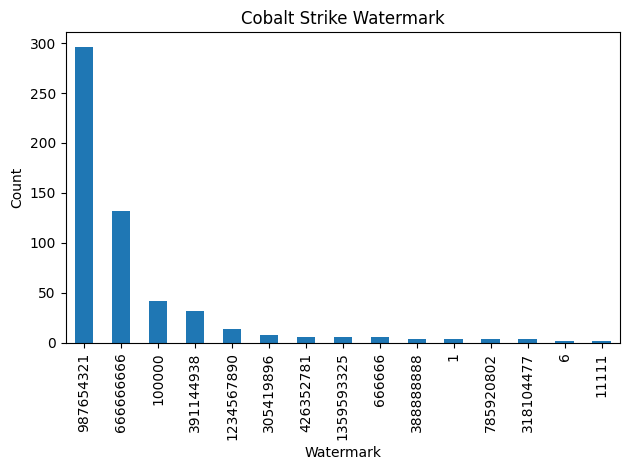

In [89]:
watermark_count = 20
watermark_list = final_df["settings.SETTING_WATERMARK"].value_counts()
watermark_num = watermark_list.head(watermark_count)
watermark_num.plot(kind="bar")
plt.title("Cobalt Strike Watermark")
plt.xlabel("Watermark")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [93]:
final_df[final_df["settings.SETTING_WATERMARK"] == 6]

,date,timestamp,hash,version,watermark,trial,protocol,settings.SETTING_PROTOCOL,settings.SETTING_PORT,settings.SETTING_SLEEPTIME,settings.SETTING_MAXGET,settings.SETTING_JITTER,settings.SETTING_PUBKEY,settings.SETTING_DOMAINS,settings.SETTING_DOMAIN_STRATEGY,settings.SETTING_DOMAIN_STRATEGY_SECONDS,settings.SETTING_DOMAIN_STRATEGY_FAIL_X,settings.SETTING_DOMAIN_STRATEGY_FAIL_SECONDS,settings.SETTING_SPAWNTO,settings.SETTING_SPAWNTO_X86,settings.SETTING_SPAWNTO_X64,settings.SETTING_CRYPTO_SCHEME,settings.SETTING_C2_VERB_GET,settings.SETTING_C2_VERB_POST,settings.SETTING_C2_CHUNK_POST,settings.SETTING_WATERMARK,settings.SETTING_WATERMARKHASH,settings.SETTING_CLEANUP,settings.SETTING_CFG_CAUTION,settings.SETTING_MAX_RETRY_STRATEGY_ATTEMPTS,settings.SETTING_MAX_RETRY_STRATEGY_INCREASE,settings.SETTING_MAX_RETRY_STRATEGY_DURATION,settings.SETTING_USERAGENT,settings.SETTING_SUBMITURI,settings.SETTING_C2_RECOVER,settings.SETTING_C2_REQUEST,settings.SETTING_C2_POSTREQ,settings.SETTING_HOST_HEADER,settings.SETTING_HTTP_NO_COOKIES,settings.SETTING_PROXY_BEHAVIOR,settings.SETTING_TCP_FRAME_HEADER,settings.SETTING_SMB_FRAME_HEADER,settings.SETTING_EXIT_FUNK,settings.SETTING_KILLDATE,settings.SETTING_GARGLE_NOOK,settings.SETTING_PROCINJ_PERMS_I,settings.SETTING_PROCINJ_PERMS,settings.SETTING_PROCINJ_MINALLOC,settings.SETTING_PROCINJ_TRANSFORM_X86,settings.SETTING_PROCINJ_TRANSFORM_X64,settings.SETTING_PROCINJ_STUB,settings.SETTING_PROCINJ_EXECUTE,settings.SETTING_PROCINJ_ALLOCATOR,settings.SETTING_PROCINJ_BOF_REUSE_MEM,settings.SETTING_BOF_ALLOCATOR,settings.SETTING_MASKED_WATERMARK,settings.SETTING_SYSCALL_METHOD,source_file,settings.SETTING_DATA_STORE_SIZE,settings.SETTING_GARGLE_SECTIONS,settings.SETTING_MAXDNS,settings.SETTING_PIPENAME,settings.SETTING_DNS_IDLE,settings.SETTING_DNS_SLEEP,settings.SETTING_BEACON_GATE
187,2025-12-12T00:12:17.921535,1970-01-01 00:00:01.765494737,bf2ffa96f61316071a5dff6da37d269efcdcd47381a06fc2a3934ae5b2b84afb,"Cobalt Strike 4.4 (Aug 04, 2021)",6,False,http,0,7777,60000,1048576,0,1f4a2523745712b91c6daf07c7649049527b83a17267efa3a47a64c892958cbd,"114.242.13.218,/en_US/all.js",0.0,4.294967e+09,4.294967e+09,4.294967e+09,00000000000000000000000000000000,%windir%\syswow64\rundll32.exe,%windir%\sysnative\rundll32.exe,0,GET,POST,0,6,NaN,0,0,NaN,NaN,NaN,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; BOIE9;ENCA),/submit.php,"[[print, True]]","[[BUILD, metadata], [BASE64, True], [HEADER, Cookie]]","[[_HEADER, Content-Type: application/octet-stream], [BUILD, id], [PARAMETER, id], [BUILD, output], [PRINT, True]]",,1.0,2.0,,,0.0,0.0,0.0,64.0,64.0,0.0,"[[append, ], [prepend, ]]","[[append, ], [prepend, ]]",00000000000000000000000000000000,"[CreateThread, SetThreadContext, CreateRemoteThread, RtlCreateUserThread]",0.0,NaN,NaN,NaN,NaN,114.242.13.218-7777_x86config.json,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526,2025-12-12T00:12:21.632482,1970-01-01 00:00:01.765494741,11cb76ddfcf3a03e3603ddc51906719ba011633bb326d0ad392ee48ecd0d0bec,Unknown,6,False,http,0,7777,60000,1048576,0,1f4a2523745712b91c6daf07c7649049527b83a17267efa3a47a64c892958cbd,"114.242.13.218,/match",0.0,4.294967e+09,4.294967e+09,4.294967e+09,00000000000000000000000000000000,%windir%\syswow64\rundll32.exe,%windir%\sysnative\rundll32.exe,0,GET,POST,0,6,NaN,0,0,NaN,NaN,NaN,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; MALC),/submit.php,"[[print, True]]","[[BUILD, metadata], [BASE64, True], [HEADER, Cookie]]","[[_HEADER, Content-Type: application/octet-stream], [BUILD, id], [PARAMETER, id], [BUILD, output], [PRINT, True]]",,1.0,2.0,,,0.0,0.0,0.0,64.0,64.0,0.0,"[[append, ], [prepend, ]]","[[append, ], [prepend, ]]",00000000000000000000000000000000,"[CreateThread, SetThreadContext, CreateRemoteThread, RtlCreateUserThread]",0.0,NaN,NaN,NaN,NaN,114.242.13.218-7777_x64config.json,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Censys query to hunt for the user agent

[CS User Agent](https://platform.censys.io/search?q=%28host.services.endpoints.cobalt_strike.x64.user_agent%3D%22Mozilla%2F5.0+%28compatible%3B+MSIE+9.0%3B+Windows+NT+6.1%3B+WOW64%3B+Trident%2F5.0%3B+BOIE9%3BENCA%29%22+OR+host.services.endpoints.cobalt_strike.x86.user_agent%3D%22Mozilla%2F5.0+%28compatible%3B+MSIE+9.0%3B+Windows+NT+6.1%3B+WOW64%3B+Trident%2F5.0%3B+BOIE9%3BENCA%29%22%29+and+host.ip%3A+*&org=31a7bac9-0070-4e2e-bbb2-c94d335a7c0f)

In [192]:
final_df.groupby(["version", "settings.SETTING_WATERMARK"]).size().sort_values(ascending=False)

version                              settings.SETTING_WATERMARK
Cobalt Strike 4.9 (Sep 19, 2023)     987654321                     145
                                     666666666                     131
Cobalt Strike 4.8 (Feb 28, 2023)     987654321                     130
Cobalt Strike 4.7 (Aug 17, 2022)     391144938                      32
Unknown                              100000                         21
Cobalt Strike 4.5 (Dec 14, 2021)     100000                         21
Cobalt Strike 4.7 (Aug 17, 2022)     987654321                      14
Unknown                              987654321                       7
Cobalt Strike 4.3 (Mar 03, 2021)     426352781                       6
Unknown                              1234567890                      5
Cobalt Strike 4.4 (Aug 04, 2021)     1234567890                      5
Unknown                              305419896                       4
Cobalt Strike 4.0 (Dec 05, 2019)     305419896                       4
Cobalt Strike

# Put it all together

In [ ]:
final_df.groupby("settings.SETTING_PUBKEY")["settings.SETTING_DOMAINS"].nunique().sort_values(ascending=False)

In [ ]:
final_df.groupby(["settings.SETTING_PUBKEY", "settings.SETTING_PORT"]).size()

In [203]:
comparison_df[
    comparison_df["settings.SETTING_PROCINJ_EXECUTE_x86"]
    != comparison_df["settings.SETTING_PROCINJ_EXECUTE_x64"]
]

,ip,port,date_x86,timestamp_x86,hash_x86,version_x86,watermark_x86,trial_x86,protocol_x86,settings.SETTING_PROTOCOL_x86,settings.SETTING_PORT_x86,settings.SETTING_SLEEPTIME_x86,settings.SETTING_MAXGET_x86,settings.SETTING_JITTER_x86,settings.SETTING_PUBKEY_x86,settings.SETTING_DOMAINS_x86,settings.SETTING_DOMAIN_STRATEGY_x86,settings.SETTING_DOMAIN_STRATEGY_SECONDS_x86,settings.SETTING_DOMAIN_STRATEGY_FAIL_X_x86,settings.SETTING_DOMAIN_STRATEGY_FAIL_SECONDS_x86,settings.SETTING_SPAWNTO_x86,settings.SETTING_SPAWNTO_X86_x86,settings.SETTING_SPAWNTO_X64_x86,settings.SETTING_CRYPTO_SCHEME_x86,settings.SETTING_C2_VERB_GET_x86,settings.SETTING_C2_VERB_POST_x86,settings.SETTING_C2_CHUNK_POST_x86,settings.SETTING_WATERMARK_x86,settings.SETTING_WATERMARKHASH_x86,settings.SETTING_CLEANUP_x86,settings.SETTING_CFG_CAUTION_x86,settings.SETTING_MAX_RETRY_STRATEGY_ATTEMPTS_x86,settings.SETTING_MAX_RETRY_STRATEGY_INCREASE_x86,settings.SETTING_MAX_RETRY_STRATEGY_DURATION_x86,settings.SETTING_USERAGENT_x86,settings.SETTING_SUBMITURI_x86,settings.SETTING_C2_RECOVER_x86,settings.SETTING_C2_REQUEST_x86,settings.SETTING_C2_POSTREQ_x86,settings.SETTING_HOST_HEADER_x86,settings.SETTING_HTTP_NO_COOKIES_x86,settings.SETTING_PROXY_BEHAVIOR_x86,settings.SETTING_TCP_FRAME_HEADER_x86,settings.SETTING_SMB_FRAME_HEADER_x86,settings.SETTING_EXIT_FUNK_x86,settings.SETTING_KILLDATE_x86,settings.SETTING_GARGLE_NOOK_x86,settings.SETTING_PROCINJ_PERMS_I_x86,settings.SETTING_PROCINJ_PERMS_x86,settings.SETTING_PROCINJ_MINALLOC_x86,settings.SETTING_PROCINJ_TRANSFORM_X86_x86,settings.SETTING_PROCINJ_TRANSFORM_X64_x86,settings.SETTING_PROCINJ_STUB_x86,settings.SETTING_PROCINJ_EXECUTE_x86,settings.SETTING_PROCINJ_ALLOCATOR_x86,settings.SETTING_PROCINJ_BOF_REUSE_MEM_x86,settings.SETTING_BOF_ALLOCATOR_x86,settings.SETTING_MASKED_WATERMARK_x86,settings.SETTING_SYSCALL_METHOD_x86,settings.SETTING_DATA_STORE_SIZE_x86,settings.SETTING_GARGLE_SECTIONS_x86,settings.SETTING_MAXDNS_x86,settings.SETTING_PIPENAME_x86,settings.SETTING_DNS_IDLE_x86,settings.SETTING_DNS_SLEEP_x86,settings.SETTING_BEACON_GATE_x86,date_x64,timestamp_x64,hash_x64,version_x64,watermark_x64,trial_x64,protocol_x64,settings.SETTING_PROTOCOL_x64,settings.SETTING_PORT_x64,settings.SETTING_SLEEPTIME_x64,settings.SETTING_MAXGET_x64,settings.SETTING_JITTER_x64,settings.SETTING_PUBKEY_x64,settings.SETTING_DOMAINS_x64,settings.SETTING_DOMAIN_STRATEGY_x64,settings.SETTING_DOMAIN_STRATEGY_SECONDS_x64,settings.SETTING_DOMAIN_STRATEGY_FAIL_X_x64,settings.SETTING_DOMAIN_STRATEGY_FAIL_SECONDS_x64,settings.SETTING_SPAWNTO_x64,settings.SETTING_SPAWNTO_X86_x64,settings.SETTING_SPAWNTO_X64_x64,settings.SETTING_CRYPTO_SCHEME_x64,settings.SETTING_C2_VERB_GET_x64,settings.SETTING_C2_VERB_POST_x64,settings.SETTING_C2_CHUNK_POST_x64,settings.SETTING_WATERMARK_x64,settings.SETTING_WATERMARKHASH_x64,settings.SETTING_CLEANUP_x64,settings.SETTING_CFG_CAUTION_x64,settings.SETTING_MAX_RETRY_STRATEGY_ATTEMPTS_x64,settings.SETTING_MAX_RETRY_STRATEGY_INCREASE_x64,settings.SETTING_MAX_RETRY_STRATEGY_DURATION_x64,settings.SETTING_USERAGENT_x64,settings.SETTING_SUBMITURI_x64,settings.SETTING_C2_RECOVER_x64,settings.SETTING_C2_REQUEST_x64,settings.SETTING_C2_POSTREQ_x64,settings.SETTING_HOST_HEADER_x64,settings.SETTING_HTTP_NO_COOKIES_x64,settings.SETTING_PROXY_BEHAVIOR_x64,settings.SETTING_TCP_FRAME_HEADER_x64,settings.SETTING_SMB_FRAME_HEADER_x64,settings.SETTING_EXIT_FUNK_x64,settings.SETTING_KILLDATE_x64,settings.SETTING_GARGLE_NOOK_x64,settings.SETTING_PROCINJ_PERMS_I_x64,settings.SETTING_PROCINJ_PERMS_x64,settings.SETTING_PROCINJ_MINALLOC_x64,settings.SETTING_PROCINJ_TRANSFORM_X86_x64,settings.SETTING_PROCINJ_TRANSFORM_X64_x64,settings.SETTING_PROCINJ_STUB_x64,settings.SETTING_PROCINJ_EXECUTE_x64,settings.SETTING_PROCINJ_ALLOCATOR_x64,settings.SETTING_PROCINJ_BOF_REUSE_MEM_x64,settings.SETTING_BOF_ALLOCATOR_x64,settings.SETTING_MASKED_WATERMARK_x64,settings.SETTING_SYSCALL_METHOD_x64,settings.SETTING_DATA_STORE_SIZE_x64,settings.SETTING